# Train with Keras, evaluate with PyTorch

Here I want to share an example of how you can train a model with [Keras](https://keras.io) using [PlaidML](https://github.com/plaidml/plaidml) backend, and transfer the pre-trained weights into a [PyTorch](https://pytorch.org) model for evaluation. You can also use [Tensorflow](https://www.tensorflow.org) backend for Keras if you wish, the code stays pretty much the same.

PS. PlaidML supports GPU acceleration on MacOS, which is the main reason why I am doing this. Enjoy :)

# 1. Preparation

## Imports

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
import torch
import numpy as np
import matplotlib.pyplot as plt

from data.utils import show_all_keypoints
from data.download_utils import extract_archive
from data.facial_keypoints_dataset import FacialKeypointsDataset
from data.facial_keypoints_sequence import FacialKeypointsSequence
from models.model_constructor import ModelConstructor
from models.utils import copy_weights_from_keras_to_pytorch, weights_are_equal, get_scores

torch.set_default_dtype(torch.float64)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using plaidml.keras.backend backend.


## Load and visualize data

We will be using [Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/overview) dataset in this notebook. The below code extracts the data and reads the datasets into memory.

In [2]:
# extract the data into datasets directory
repo_root = os.path.abspath(os.getcwd())
dataset_path = os.path.join(repo_root, "data", "facial_keypoints.zip")
data_root = os.path.join(repo_root, "datasets", "facial_keypoints_data")
extract_archive(dataset_path, to_path=data_root)

# create train and val datasets
train_dataset = FacialKeypointsDataset(
    train=True,
    root=data_root,
)
val_dataset = FacialKeypointsDataset(
    train=False,
    root=data_root,
)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

image, keypoints = train_dataset[0]
print("Shape of the image:", image.shape)
print("Smallest value in the image:", np.min(image))
print("Largest value in the image:", np.max(image))
print("Keypoints:\n", keypoints)

Number of training samples: 1546
Number of validation samples: 298
Shape of the image: (1, 96, 96)
Smallest value in the image: 0.011764705882352941
Largest value in the image: 1.0
Keypoints:
 [[ 0.46853801 -0.23185731]
 [-0.42527485 -0.19526784]
 [ 0.29081871 -0.22140351]
 [ 0.59921637 -0.22140351]
 [-0.26846784 -0.21094971]
 [-0.58730994 -0.19004094]
 [ 0.19672515 -0.38272982]
 [ 0.76555556 -0.4295345 ]
 [-0.20350877 -0.37579181]
 [-0.73890058 -0.35730526]
 [ 0.0085614   0.23334503]
 [ 0.41626901  0.66195322]
 [-0.35209357  0.69854971]
 [ 0.01378947  0.60445614]
 [ 0.01901754  0.90762573]]


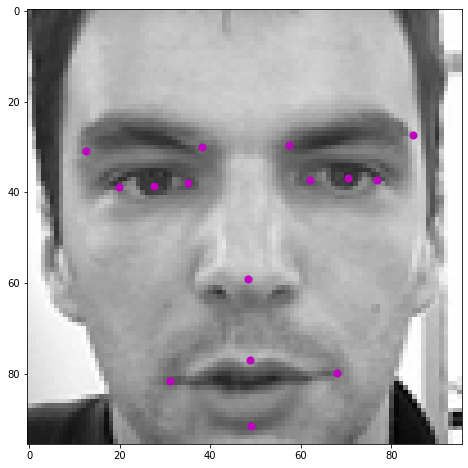

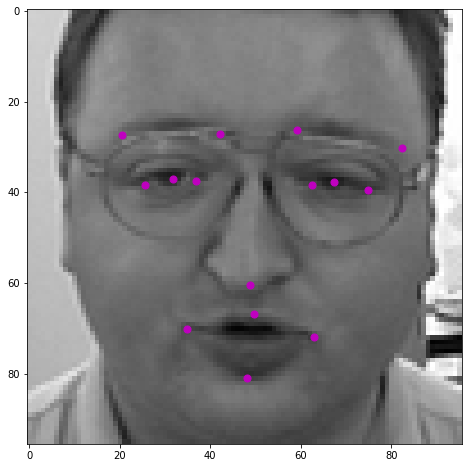

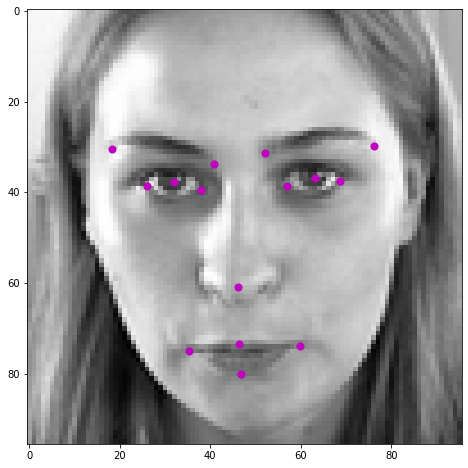

In [3]:
def show_keypoints(dataset, num_samples=3):
    for i in range(num_samples):
        img, key_pts = dataset[i]
        show_all_keypoints(img, key_pts)
show_keypoints(train_dataset)

# 2. Facial keypoints detection

### 2.1 Define the model

In [4]:
input_shape = (1, 96, 96)
conv_layers = [
    {            # 32 x 48 x 48
        "filters": 32,
        "kernel_size": 3,
        "strides": 1,
        "padding": "same",
        "activation": "relu",
        "max_pooling": {
            "size": (2, 2),
        },
    }, {         # 64 x 24 x 24
        "filters": 64,
        "kernel_size": 3,
        "strides": 1,
        "padding": "same",
        "activation": "relu",
        "max_pooling": {
            "size": (2, 2),
        },
    }, {         # 128 x 12 x 12
        "filters": 128,
        "kernel_size": 3,
        "strides": 1,
        "padding": "same",
        "activation": "relu",
        "max_pooling": {
            "size": (2, 2),
        },
    }, {         # 192 x 6 x 6
        "filters": 192,
        "kernel_size": 3,
        "strides": 1,
        "padding": "same",
        "activation": "relu",
        "max_pooling": {
            "size": (2, 2),
        },
    }, {         # 256 x 3 x 3
        "filters": 256,
        "kernel_size": 3,
        "strides": 1,
        "padding": "same",
        "activation": "relu",
        "max_pooling": {
            "size": (2, 2),
        },
    }, 
]
dense_layers = [
    {
        "input_units": 256*3*3,
        "units": 512,
        "activation": "relu",
    }, {
        "input_units": 512,
        "units": 30,
        "activation": "tanh",
    }
]
model_constructor = ModelConstructor(input_shape, conv_layers, dense_layers)

### 2.2 Construct Keras model

In [5]:
keras_model = model_constructor.get_keras_model(verbose=True)

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 96, 96)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 48, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 48, 48)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 24, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 24, 24)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 12, 12)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 192, 12, 12)       221376    
__________

### 2.3 Train keras model

Unfortunately, it turns out that Keras with PlaidML backend does not yet support feeding model from data generator while training.

In [6]:
# THIS WILL THROW AN ERROR:

# batch_size = 128
# epochs = 30
# train_sequence = FacialKeypointsSequence(train_dataset, batch_size)
# val_sequence = FacialKeypointsSequence(val_dataset, batch_size)

# keras_model.compile(optimizer="adam", loss="mean_squared_error")
# keras_model.fit(train_sequence, batch_size=batch_size, epochs=epochs, validation_data=val_sequence)

# AttributeError: 'FacialKeypointsSequence' object has no attribute 'ndim'

So we will simply load all the data into a numpy array to train our model.

In [ ]:
x_train = []
y_train = []

for i in range(len(train_dataset)):
    x, y = train_dataset[i]
    x_train.append(x)
    y_train.append(y.flatten())

x_val = []
y_val = []

for i in range(len(val_dataset)):
    x, y = val_dataset[i]
    x_val.append(x)
    y_val.append(y.flatten())

keras_model.compile(optimizer="adam", loss="mean_squared_error")
keras_model.fit(np.array(x_train), np.array(y_train),
                batch_size=128, epochs=10,
                validation_data=(np.array(x_val), np.array(y_val)))

Train on 1546 samples, validate on 298 samples
Epoch 1/10
1152/1546 [=====================>........] - ETA: 1s - loss: 0.0508

### 2.4 Transfer pre-trained weights to a PyTorch model

In [ ]:
pt_model = copy_weights_from_keras_to_pytorch(keras_model, model_constructor.get_pytorch_model(verbose=True))

# make sure weights are equal
weights_are_equal(keras_model, pt_model)

### 2.5 Evaluate both models on validation data

In [ ]:
get_scores(np.array(x_val), np.array(y_val), keras_model, pt_model)

### 2.5.1 Denial

Oh wait...but why?! Why does my PyTorch model evaluates with a so terrible loss? Maybe weights are not that equal, let's check again!

In [ ]:
# make sure weights are equal
weights_are_equal(keras_model, pt_model)

### 2.5.2 Anger

(sensored)

### 2.5.3 Bargaining

(spend the whole night trying to find a workaround)

(plot some predictions)

In [ ]:
def show_keras_keypoint_predictions(model, dataset, num_samples=3):
    for i in range(num_samples):
        image, key_pts = dataset[i]
        image = image.reshape(1, 1, 96, 96)
        predicted_keypoints = keras_model.predict(image).reshape(15, 2)
        show_all_keypoints(image, key_pts, predicted_keypoints)

def show_pt_keypoint_predictions(model, dataset, num_samples=3):
    for i in range(num_samples):
        image, key_pts = dataset[i]
        predicted_keypoints = torch.squeeze(model(
            torch.from_numpy(image).unsqueeze(0)).detach()).view(15,2).numpy()
        show_all_keypoints(image, key_pts, predicted_keypoints)
        
show_keras_keypoint_predictions(keras_model, val_dataset, num_samples=1)
show_pt_keypoint_predictions(pt_model, val_dataset, num_samples=1)

### 2.5.4 Depression

(...)

### 2.5.5 Acceptance

Yeah, well...at least I have tried.

If you find any bug in my code or you know the reason why this doesn't this approach work - please, let me know by opening an issue. Thanks :)